<center> <img src='https://upload.wikimedia.org/wikipedia/commons/thumb/d/dd/Booking.com_Logo.svg/1280px-Booking.com_Logo.svg.png' style='width:400px;'>

# <p style="text-align:center;font-size:100%;">0. Introduction </p>

**Case Description**
There is one hot problem in company - the dishonest hotels fake star ratings.

**Task**
* Using the data to build a model that predicts the rating of the hotel.
* If the predictions of the model are very different from the actual result, then perhaps the hotel is being dishonest and worth checking.

**Metrics:** MAPE

**Data:** The csv file contains 17 fields

* hotel_address: street, post code, city, country
* additional_number_of_scoring: number of scores without review
* review_date: day of review.
* average_score: average rating of the hotel
* hotel_name: full name of hotel
* reviewer_nationality: nationality of reviewer (country name)
* negative_review: text of negative review ('No Negative' if no negative feedback)
* review_total_negative_word_counts: total number of words in the negative review
* total_number_of_reviews: total number of valid reviews the hotel has
* positive_review: text of positive review ('No Positive' if no positive feedback)
* review_total_positive_word_counts: total number of words in the positive review
* total_number_of_reviews_reviewer_has_given: number of reviews the reviewers has given
* reviewer_score: number of reviewer score (TARGET value)
* tags: tags reviewer gave the hotel (type of room, purpose of trip, counts of stayed nights etc.)
* days_since_review: Duration between the review date and scrape date
* lat: Latitude of the hotel location
* lng: longtitude of the hotel location

# <p style="text-align:center;font-size:100%;">1. Install and Import</p>

In [1]:
# Installing libs
!pip install nltk[twitter]

import os
import time
import numpy as np
import pandas as pd

# Libs for visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline

# For counting unique elements number (tags)
from collections import Counter

# For multiple merging
from functools import reduce

# For calculate distance (coordinates)
import haversine as hs

# Additional packages
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')

# Encoding
import category_encoders as ce

# Libs for machine learning
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor 
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
/kaggle/input/sf-booking/hotels_test.csv
/kaggle/input/sf-booking/hotels_train.csv
/kaggle/input/sf-booking/submission.csv


In [2]:
# Fixing RANDOM_SEED to make experiment repetable
RANDOM_SEED = 42

# Fixing package versions to make experiment repetable
!pip freeze > requirements.txt

# <p style="text-align:center;font-size:100%;">2. Data Loading</p>

In [3]:
DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv(DATA_DIR+'/hotels_train.csv') # dataset for training
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') # dataset for prediction
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv') # submission

***

## Joining train and test data

In [4]:
"""Joining train and test data into one main dataset for the correct feature processing
- Marking train and test data
- Marking 0 reviewer_score values in test data
"""
df_train['sample'] = 1
df_test['sample'] = 0
df_test['reviewer_score'] = 0

data = df_test.append(df_train, sort=False).reset_index(drop=True)
data.head(8)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,11/26/2015,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,15,"[' Business trip ', ' Solo traveler ', ' Twin ...",616 day,41.393192,2.161520,0,0.0
3,Piazza Della Repubblica 17 Central Station 201...,241,10/17/2015,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,9,"[' Leisure trip ', ' Couple ', ' Ambassador Ju...",656 day,45.479888,9.196298,0,0.0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,5/16/2016,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,2,"[' Business trip ', ' Solo traveler ', ' Class...",444 day,52.370545,4.888644,0,0.0
5,Coram Street Camden London WC1N 1HT United Kin...,709,8/13/2015,8.2,Holiday Inn London Bloomsbury,Ecuador,They don t have free wifi,7,2995,The location is perfect if you don t have a l...,26,3,"[' Business trip ', ' Solo traveler ', ' Stand...",721 day,51.524125,-0.125807,0,0.0
6,Empire Way Wembley Brent London HA9 8DS United...,1005,8/18/2016,8.3,Holiday Inn London Wembley,United Kingdom,Room generally a bit shabby with some lack of...,35,3469,Location price It did not cost much more to h...,23,11,"[' Leisure trip ', ' Couple ', ' Queen Room ',...",350 day,51.559095,-0.284704,0,0.0
7,1 Shortlands Hammersmith and Fulham London W6 ...,704,8/11/2015,8.3,Novotel London West,Netherlands,Executive rooms 9th Floor don t have a bath T...,52,2443,Comphy bed upgraded to executive room with ne...,42,38,"[' Business trip ', ' Solo traveler ', ' Execu...",723 day,51.491959,-0.220096,0,0.0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   review_date                                 515738 non-null  object 
 3   average_score                               515738 non-null  float64
 4   hotel_name                                  515738 non-null  object 
 5   reviewer_nationality                        515738 non-null  object 
 6   negative_review                             515738 non-null  object 
 7   review_total_negative_word_counts           515738 non-null  int64  
 8   total_number_of_reviews                     515738 non-null  int64  
 9   positive_review                             515738 non-null  object 
 

***

# <p style="text-align:center;font-size:100%;">3. Checking dataset: outliers, duplicates</p>

In [6]:
print(f'Total number of rows: {data.shape[0]}')

# duplicates
all_columns = list(data.columns)
mask_dupl = data.duplicated(subset=all_columns) 
data_duplicates = data[mask_dupl]
print(f'Number of found duplicates: {data_duplicates.shape[0]}')

# features with missing values
nulls_data = data.isnull().sum()
nulls = nulls_data[nulls_data > 0]
print(f'Features with nulls: {nulls_data[nulls_data>0].count()}\n{nulls}')

Total number of rows: 515738
Number of found duplicates: 336
Features with nulls: 2
lat    3268
lng    3268
dtype: int64


* After joining train and test data I get **336 duplicates.**

*By the Data Cleaning rules I should delete full duplicates, but in this case I do not do it in order to get correct submission file.*

* There are 2 columns with Missing Values - lat, lng coordinates of location.

*I can fill Missing Values by using other observations from the dataset. Let's consider this point further*

In [7]:
# Statistic information of Numeric data (without lat and lng columns)
data[['review_total_negative_word_counts', 'review_total_positive_word_counts',
      'total_number_of_reviews_reviewer_has_given', 'total_number_of_reviews',
      'additional_number_of_scoring', 'average_score']].describe().round(1)

,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,total_number_of_reviews,additional_number_of_scoring,average_score
count,515738.0,515738.0,515738.0,515738.0,515738.0,515738.0
mean,18.5,17.8,7.2,2743.7,498.1,8.4
std,29.7,21.8,11.0,2317.5,500.5,0.5
min,0.0,0.0,1.0,43.0,1.0,5.2
25%,2.0,5.0,1.0,1161.0,169.0,8.1
50%,9.0,11.0,3.0,2134.0,341.0,8.4
75%,23.0,22.0,8.0,3613.0,660.0,8.8
max,408.0,395.0,355.0,16670.0,2682.0,9.8


* `MAX value of the next Features is very different from values which is included in interquartile range (IQR).`
    - review_total_negative_word_counts,
    - review_total_positive_word_counts,
    - total_number_of_reviews_reviewer_has_given,
    - total_number_of_reviews
    - additional_number_of_scoring
    
Also we should check *reviewer_score* and *average_score* in order to look at the MIN value distribution

-> Let's create a graph to visialize outliers

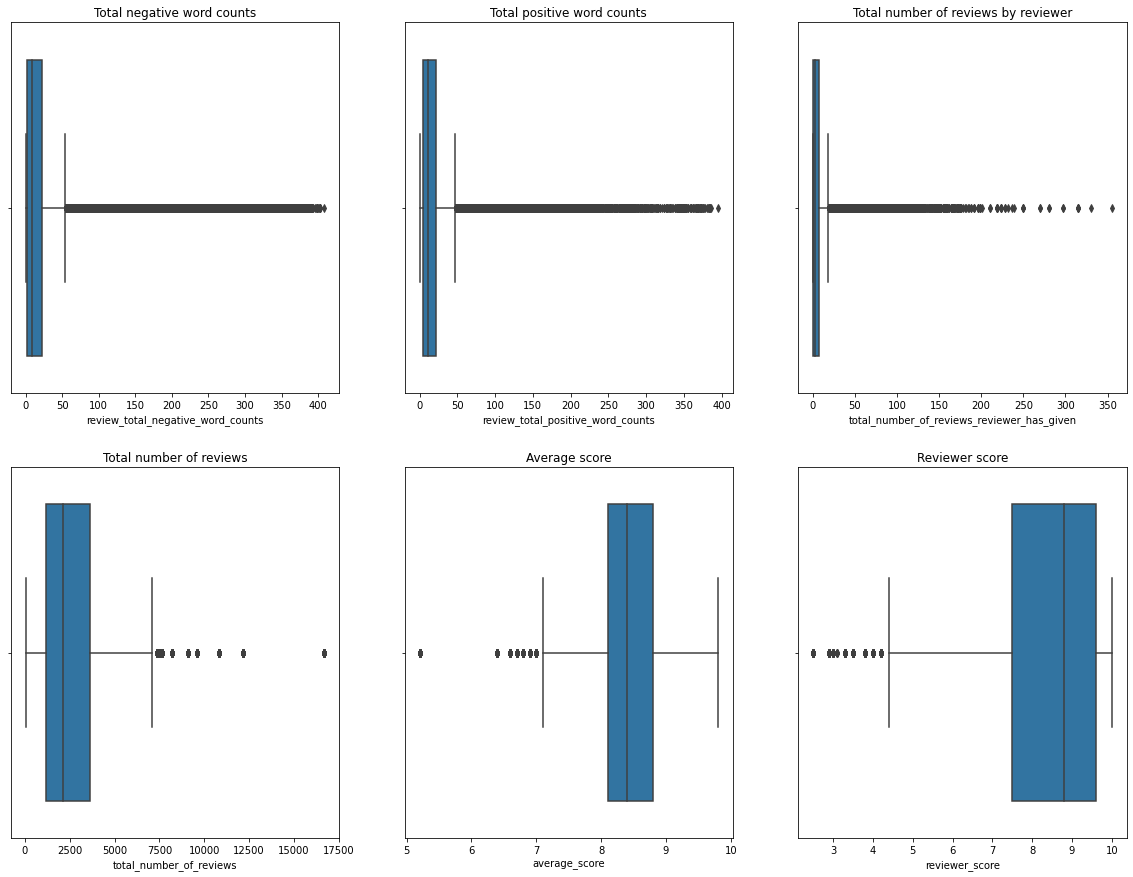

In [8]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 15))

boxplot = sns.boxplot(
    data=data, 
    x='review_total_negative_word_counts', 
    ax=axes[0,0]);
boxplot.set_title('Total negative word counts');

boxplot = sns.boxplot(
    data=data, 
    x='review_total_positive_word_counts', 
    ax=axes[0,1]);
boxplot.set_title('Total positive word counts');

boxplot = sns.boxplot(
    data=data, 
    x='total_number_of_reviews_reviewer_has_given', 
    ax=axes[0,2]);
boxplot.set_title('Total number of reviews by reviewer');

boxplot = sns.boxplot(
    data=data, 
    x='total_number_of_reviews', 
    ax=axes[1,0]);
boxplot.set_title('Total number of reviews');

boxplot = sns.boxplot(
    data=data, 
    x='average_score', 
    ax=axes[1,1]);
boxplot.set_title('Average score');

# creating mask that filters dataset by sample (only train data has reviewer score value)
mask_with_score = data['sample']==1

boxplot = sns.boxplot(
    data=data[mask_with_score], 
    x='reviewer_score',
    ax=axes[1,2]);
boxplot.set_title('Reviewer score');

### `Let's look at the example of outliers`

In [9]:
display(data[data['review_total_negative_word_counts'] > 400]['hotel_name'].count())
data[data['review_total_negative_word_counts'] > 400]['negative_review']

6

63845      The customer service was really bad On arriva...
136910     First of all i want to start with saying that...
189549     The staff Had a bad experience even after boo...
261504     I did not like how the management handled my ...
271095     I didn t like the fact that when I wrote an e...
445467     WANT TO BE HAPPY IN LONDON DON T EVER GO TO C...
Name: negative_review, dtype: object

In [10]:
display(data[data['review_total_positive_word_counts'] > 385]['hotel_name'].count())
data[data['review_total_positive_word_counts'] > 385]['positive_review']

2

436115     The main reason why i chose to stay at this h...
513113     When we got there everything looked and seeme...
Name: positive_review, dtype: object

In [11]:
display(data[data['total_number_of_reviews_reviewer_has_given'] > 300]['reviewer_nationality'].count())
data[data['total_number_of_reviews_reviewer_has_given'] > 300]['total_number_of_reviews_reviewer_has_given']

6

71933     315
95346     315
166951    315
238622    315
283756    330
470300    355
Name: total_number_of_reviews_reviewer_has_given, dtype: int64

In [12]:
# Look at the values of total_number_of_reviews columns
display(data[data['total_number_of_reviews'] > 9_000]['hotel_address'].count())

# As you can see these values are repeated because the hotel name is the same. Let`s look at the unique number
display(list(data[data['total_number_of_reviews'] > 9_000]['total_number_of_reviews'].unique()))

print('\nOnly 5 hotels have more than 9 thousand reviews: 3 hotels located in London and 2 in Italy')
print()
display(data[data['total_number_of_reviews'] > 9_000]['hotel_name'].value_counts())

16209

[16670, 9568, 9086, 12158, 10842]


Only 5 hotels have more than 9 thousand reviews: 3 hotels located in London and 2 in Italy



Britannia International Hotel Canary Wharf    4789
Strand Palace Hotel                           4256
Park Plaza Westminster Bridge London          4169
Hotel Da Vinci                                1877
Hotel degli Arcimboldi                        1118
Name: hotel_name, dtype: int64

In [13]:
display(data[data['average_score'] < 6]['hotel_name'].count())

print('\nHotel with average rating less than 6 point: ')
display(list(data[data['average_score'] < 6]['hotel_name'].unique())[0])

display(data[data['average_score'] < 6].head(2))

65


Hotel with average rating less than 6 point: 


'Hotel Liberty'

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
3989,Viale Bligny 56 Milan City Center 20136 Milan ...,26,10/1/2015,5.2,Hotel Liberty,Australia,Air con was ineffective so it was pretty warm...,19,465,Quiet area good breakfast and nice clean hotel,10,16,"[' Leisure trip ', ' Solo traveler ', ' Double...",672 day,45.450867,9.194866,0,0.0
5532,Viale Bligny 56 Milan City Center 20136 Milan ...,26,10/22/2015,5.2,Hotel Liberty,Turkey,Extremely dusty rooms unfriendly staff,6,465,good breakfast,3,2,"[' Leisure trip ', ' Couple ', ' Double Room '...",651 day,45.450867,9.194866,0,0.0


In [14]:
# Let's check the lowest/highest possible score
sorted(data[mask_with_score]['reviewer_score'].unique())

# From 2.5 to 10

[2.5,
 2.9,
 3.0,
 3.1,
 3.3,
 3.5,
 3.8,
 4.0,
 4.2,
 4.4,
 4.5,
 4.6,
 5.0,
 5.4,
 5.5,
 5.6,
 5.8,
 6.0,
 6.3,
 6.5,
 6.7,
 6.9,
 7.0,
 7.1,
 7.5,
 7.9,
 8.0,
 8.1,
 8.3,
 8.5,
 8.8,
 9.0,
 9.2,
 9.4,
 9.5,
 9.6,
 10.0]

In [15]:
print('Hotel number with reviewer score less than 4.5 point: ')
display(data[(data['reviewer_score'] < 4.5) & (data['sample'] == 1)]['hotel_name'].nunique())

display(data[(data['reviewer_score'] < 4.5) & (data['sample'] == 1)].head(2))

Hotel number with reviewer score less than 4.5 point: 


1202

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score
128968,163 Marsh Wall Docklands Tower Hamlets London ...,2682,2/9/2016,7.1,Britannia International Hotel Canary Wharf,United Kingdom,Personnel was very rude Housekeeping staff do...,80,9086,Location was very good to commute within Cana...,11,7,"[' Business trip ', ' Couple ', ' Standard Dou...",541 day,51.501910,-0.023221,1,3.3
128990,92 Southampton Row Camden London WC1B 4BH Unit...,429,2/17/2016,8.3,DoubleTree by Hilton London West End,United Kingdom,rooms were very small lack of privacy as we c...,99,1774,location,2,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",533 day,51.520106,-0.122139,1,3.3


***

# <p style="text-align:center;font-size:100%;">4. Visualization of correlation between numeric features</p>

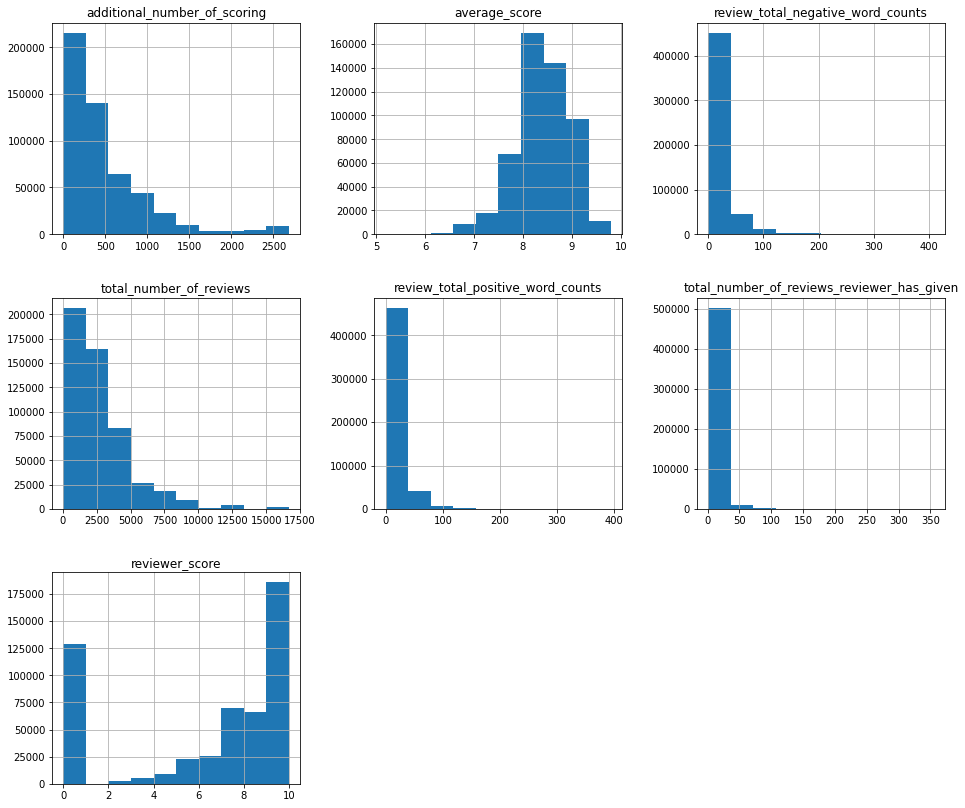

In [16]:
# Checking of Distribution ((ab/)normal)
data.drop(columns =['sample', 'lng', 'lat'], axis=1).hist(figsize=(16,14));

#### As you can see the distrubution of numeric data is **abnormal**, because histogram curve is not look as a bell.

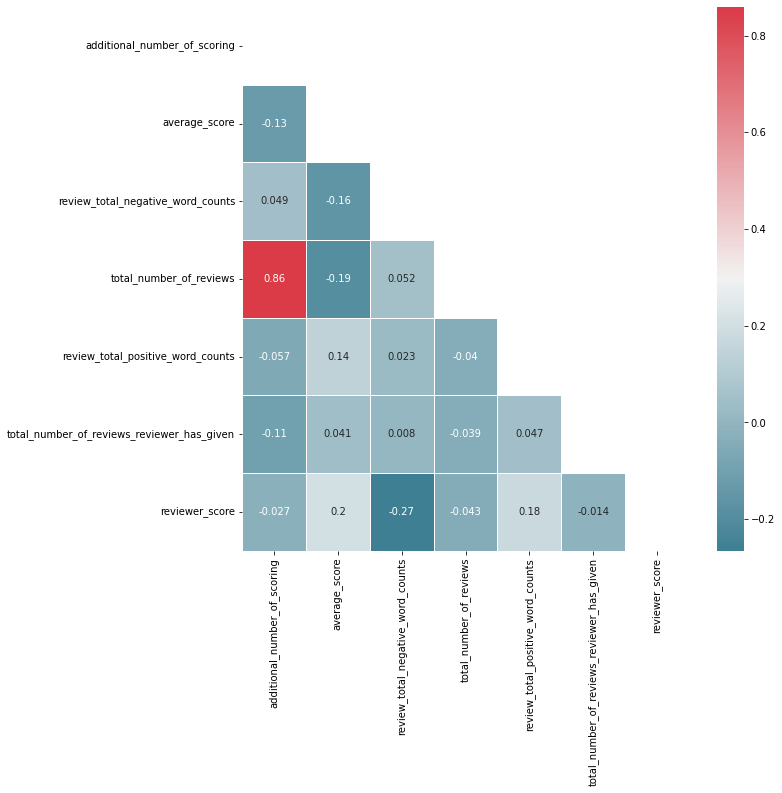

In [17]:
# Creating correlation heatmap - spearman method for abnormal distribution of numeric data
num_features = data[['additional_number_of_scoring', 'average_score', 'review_total_negative_word_counts',
                                'total_number_of_reviews', 'review_total_positive_word_counts',
                                'total_number_of_reviews_reviewer_has_given', 'reviewer_score']]

# Params for graph: color, single corner
mask = np.zeros_like(num_features.corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(num_features.corr(method='spearman'), mask=mask, cmap=cmap, linewidths=.6, annot=True, ax=ax)

plt.show();

### `Strong correlation is marked only in paar - additional_number_of_scoring & total_number_of_reviews - 0.86`

The meaning of these columns is different: number of scores without review/ feedback & total number of reviews (with/ without review). But strong correaltion usually indicates multicollinearity.

-> It is necessary to check it and decide what column should be delete.

***

# <p style="text-align:center;font-size:100%;">5. Feature Engineering</p>

In [18]:
"""
Define Unique category in each column
"""
unique_list = []
for col in data.columns:
    # creating tuple: column name, number of unique values, type
    item = (col, data[col].nunique(), data[col].dtypes)
    unique_list.append(item)
    
unique_counts = pd.DataFrame(
    unique_list,
    columns=['Column_Name', 'Num_Unique', 'Type']
).sort_values(by='Num_Unique', ignore_index=True)


display(unique_counts)

,Column_Name,Num_Unique,Type
0,sample,2,int64
1,average_score,34,float64
2,reviewer_score,38,float64
3,total_number_of_reviews_reviewer_has_given,198,int64
4,reviewer_nationality,227,object
5,review_total_positive_word_counts,365,int64
6,review_total_negative_word_counts,402,int64
7,additional_number_of_scoring,480,int64
8,review_date,731,object
9,days_since_review,731,object


***

#### `Date of Review`

In [19]:
# Converting 'review_date' column to datetime type
data['review_date'] = pd.to_datetime(data['review_date'], yearfirst=True)

print(f'Last feedback (yyyy-mm-dd): {data.review_date.max()}')
print(f'First feedback (yyyy-mm-dd): {data.review_date.min()}')

Last feedback (yyyy-mm-dd): 2017-08-03 00:00:00
First feedback (yyyy-mm-dd): 2015-08-04 00:00:00


In [20]:
"""Getting the next information from date column
- year/ month/ day
- day of week
- weekend or not
- season

-> int type
"""
data['year'] = data['review_date'].dt.year.astype(int)
data['month'] = data['review_date'].dt.month.astype(int)
data['day'] = data['review_date'].dt.day.astype(int)

data['day_of_week'] = data['review_date'].dt.dayofweek.astype(int)
data['is_weekend'] = data['day_of_week'].apply(lambda x: 1 if x>4 else 0)

data['spring'] = data['month'].apply(lambda x: 1 if x in [3,4,5] else 0)
data['summer'] = data['month'].apply(lambda x: 1 if x in [6,7,8] else 0)
data['autumn'] = data['month'].apply(lambda x: 1 if x in [9,10,11] else 0)
data['winter'] = data['month'].apply(lambda x: 1 if x in [12,1,2] else 0)

data.drop(['review_date'], inplace=True, axis=1)

data.head()

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,reviewer_score,year,month,day,day_of_week,is_weekend,spring,summer,autumn,winter
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0.0,2017,7,21,4,0,0,1,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0.0,2016,12,12,0,0,0,0,0,1
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,0.0,2015,11,26,3,0,0,0,1,0
3,Piazza Della Repubblica 17 Central Station 201...,241,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,0.0,2015,10,17,5,1,0,0,1,0
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,0.0,2016,5,16,0,0,1,0,0,0


***

#### `Days since Review`

In [21]:
# Extracting numeric value
data['days_since_review'] = data['days_since_review'].str.extract('(\d+)').astype(int)

We can check reviews by freshness measure: more than 180 days or not.

I guess that 6 months are not so long time for global changes in hotel service.

In [22]:
data['fresh_review'] = data['days_since_review'].apply(lambda x: 1 if x <= 180 else 0)

***

#### `Hotel Address`

In [23]:
print(data['hotel_address'][0])
print(data['hotel_address'][5])

Via Senigallia 6 20161 Milan Italy
Coram Street Camden London WC1N 1HT United Kingdom


Hotel address includes the follow information:
* street,
* postcode,
* city,
* country

I guess that information about city/ country is enough.

In [24]:
"""
Function to get country tag from address
"""
def get_country(address):
    address_list = address.split(' ')
    
    # Check country name is included 'Kingdom' or not (UK) in order to get correct country name
    if address_list[-1] == 'Kingdom':
        country = address_list[-2] + ' ' + address_list[-1]
    else:
        country = address_list[-1]
   
    return country


data['hotel_country'] = data['hotel_address'].apply(get_country)
print(f'Country names: {set(data.hotel_country)}')

Country names: {'Austria', 'Spain', 'United Kingdom', 'Netherlands', 'Italy', 'France'}


In [25]:
"""
Function to get city tag from address
"""
def get_city(address):
    address_list = address.split(' ')
    
    # Check country name is included 'United' or not (UK) in order to get correct city name
    if address_list[-2] == 'United':
        city = address_list[-5]
    else:
        city = address_list[-2]
   
    return city


data['hotel_city'] = data['hotel_address'].apply(get_city)
print(f'City names: {set(data.hotel_city)}')

City names: {'Amsterdam', 'Milan', 'London', 'Vienna', 'Barcelona', 'Paris'}


* Each country corresponds to one city. That's why I can only encode one of this column and use it further.
* Let's take Country column because nationality of reviewer is also marked with country name

***

#### `Adding new column with city Population number`

In [26]:
"""Population (in thousand/ k) - from https://www.macrotrends.net/cities
I get info about population in 2017, not nowadays.
Value of city population is the value of not-urban area (different for Amsterdam, Paris (2,2 mln or 10 mln))
"""
city_population = {
    'Vienna': 1_868,
    'London' : 8_916,
    'Amsterdam': 851_573,
    'Paris' : 2_188,
    'Barcelona': 1_621,
    'Milan': 1_359
}

data['city_population_k'] = data.hotel_city.map(city_population)
data.head()

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,day_of_week,is_weekend,spring,summer,autumn,winter,fresh_review,hotel_country,hotel_city,city_population_k
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,4,0,0,1,0,0,1,Italy,Milan,1359
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,0,0,0,1,0,Netherlands,Amsterdam,851573
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,3,0,0,0,1,0,0,Spain,Barcelona,1621
3,Piazza Della Repubblica 17 Central Station 201...,241,9.1,Hotel Principe Di Savoia,United States of America,No Negative,0,1543,Everything including the nice upgrade The Hot...,27,...,5,1,0,0,1,0,0,Italy,Milan,1359
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,9.1,Hotel Esther a,United Kingdom,No Negative,0,4687,Lovely hotel v welcoming staff,7,...,0,0,1,0,0,0,0,Netherlands,Amsterdam,851573


***

#### `Hotel Name`

In [27]:
# Look at the content of this column
data['hotel_name'][-20:]

515718                Silken Gran Hotel Havana
515719                  Ambassadors Bloomsbury
515720               Pullman Barcelona Skipper
515721         Millennium Hotel London Mayfair
515722                          Fielding Hotel
515723               Apex City Of London Hotel
515724                       Alma Barcelona GL
515725    DoubleTree by Hilton London Victoria
515726                The Wittmore Adults Only
515727                            Hotel Auriga
515728                    H tel Mathis Elys es
515729               Sofitel Paris Le Faubourg
515730     Shaftesbury Hyde Park International
515731       Radisson Blu Portman Hotel London
515732           Club Quarters Hotel St Paul s
515733                         Hotel Moonlight
515734           BEST WESTERN PLUS Amedia Wien
515735                 Bloomsbury Palace Hotel
515736                  The Marble Arch London
515737                   The Nadler Kensington
Name: hotel_name, dtype: object

In [28]:
# Checking for duplicate names
hotels = data.groupby(['hotel_name'])['hotel_address'].nunique().reset_index()
display(hotels[hotels['hotel_address'] != 1])

print('Hotel named "Hotel Regina" is located in three cities/ countries')

,hotel_name,hotel_address
741,Hotel Regina,3


Hotel named "Hotel Regina" is located in three cities/ countries


In [29]:
# Let's add city name to hotel name in order to distinguish hotels in data analysis
data['hotel_name'] = data.apply(lambda x: (x['hotel_name'] + ' ' + x['hotel_city']) \
                                if (x['hotel_name'] == 'Hotel Regina') \
                                else x['hotel_name'], axis=1)

***

#### `Latitude and Longitude`

In [30]:
# Filling MV in lat and lng columns by using dict with mode value
# data[data['city'] == 'Barcelona']['lng'].mode()

# dict for lat value
city_lat = {
    'Barcelona': 41.371308,
    'Vienna': 48.214662,
    'Amsterdam':  52.370545,
    'Milan': 45.533137,
    'Paris': 48.879484,
    'London': 51.50191
}

# dict for lng value
city_lng = {
    'Barcelona': 2.181698,
    'Vienna': 16.362799,
    'Amsterdam': 4.888644,
    'Milan': 9.171102,
    'Paris': 2.355654,
    'London': -0.023221
}

# Getting a list with lat&lng MV rows
lat = list(data[data['lat'].isna()].index)
lng = list(data[data['lng'].isna()].index)

# Filling MV by dict
data.loc[lat, 'lat'] = data.loc[lat, 'hotel_city'].map(city_lat)
data.loc[lng, 'lng'] = data.loc[lng, 'hotel_city'].map(city_lng)

Now we can create new feature: distance to center from hotel.

In [31]:
data['hotel_coord'] = list(zip(data.lat, data.lng))

In [32]:
data.head(2)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,is_weekend,spring,summer,autumn,winter,fresh_review,hotel_country,hotel_city,city_population_k,hotel_coord
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0,0,1,0,0,1,Italy,Milan,1359,"(45.5331372, 9.1711019)"
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,...,0,0,0,0,1,0,Netherlands,Amsterdam,851573,"(52.3856494, 4.834443)"


In [33]:
"""
Function to calculate distance between hotel and city center
"""
def get_distance_to_center(hotel_coord, city):
    
    city_center_coord = {
    'Barcelona': (41.3870134,  2.1701276), # Catalonia Square
    'Vienna': (48.208611,  16.372222), # Stephansplatz
    'Amsterdam': (52.3730144, 4.8933578), # Dam Square
    'Milan': (45.464736, 9.188730), # Piazza del Duomo
    'Paris': (48.865597, 2.321171), # Place de la Concorde
    'London': (51.508041, -0.128055) # Trafalgar Square
}
    
    if city in city_center_coord.keys():
        distance = hs.haversine(city_center_coord[city], (hotel_coord))
    else:
        distance = np.nan
        
    return distance


# data['center_lat_lng'] = data['hotel_city'].map(city_center_coord)
data['distance_to_center'] = data.apply(lambda x: get_distance_to_center(x['hotel_coord'], x['hotel_city']), axis=1).round(2)

In [34]:
# Let's look at this new column
data.groupby(['hotel_name'])['distance_to_center'].max().reset_index().sort_values(by='distance_to_center', ascending=False)

,hotel_name,distance_to_center
258,Crowne Plaza London Ealing,17.10
493,Hallmark Hotel London Chigwell Prince Regent,16.97
146,Best Western PLUS Epping Forest,14.28
1335,The Drayton Court Hotel,13.25
798,Hotel Xanadu,12.33
...,...,...
566,Hotel Amsterdam De Roode Leeuw,0.08
265,DO CO Hotel Vienna,0.06
1300,Swiss tel Amsterdam,0.06
1432,TownHouse Duomo,0.05


***

#### `Reviewer Nationality`

In [35]:
# What reviewer nationality is the most common in the dataset?
display(data['reviewer_nationality'].value_counts())

print(f'\nNumber of reviewer nationality: {data.reviewer_nationality.nunique()}')

 United Kingdom               245246
 United States of America      35437
 Australia                     21686
 Ireland                       14827
 United Arab Emirates          10235
                               ...  
 Comoros                           1
 Anguilla                          1
 Tuvalu                            1
 Cape Verde                        1
 Palau                             1
Name: reviewer_nationality, Length: 227, dtype: int64


Number of reviewer nationality: 227


* Almost 50% of reviewers are from UK

I have 3 ideas to encode this column:
- reviewer is from UK/ not - 1/0
- reviewer is from the same country as hotel - 1/0
- encoding top-10 reviewer nationality

In [36]:
# Getting df with number of visitors by their nationality
country_of_visitors = data['reviewer_nationality'].value_counts().reset_index()
country_of_visitors.columns = ['country', 'cnt of visitors']

# Deleting space in value
data['reviewer_nationality'] = data['reviewer_nationality'].str.strip()

# Getting new column: guest from the same country or not
data['reviewer_from_same_country'] = data.apply(lambda x: 1 if (x['reviewer_nationality'] == x['hotel_country']) \
                                                else 0, axis=1)

***

#### `Tags`

In [37]:
"""
Function to get list of tags
"""
def get_tags_list(num_tags):
    # getting slice of tags without []
    num_tags = num_tags[2:-2]
    
    # getting list of tags
    res = num_tags.strip().split(' \', \' ')
    
    return res


data['tags_n'] = data['tags'].apply(get_tags_list)

In [38]:
# Getting string entry to separate rows
tags_rows = data.explode('tags_n')

# Define unique tags number (from list)
len(tags_rows['tags_n'].unique())

print('Unique number of tags in data:', len(tags_rows['tags_n'].unique()))
print('Total number of tags in data:', len(tags_rows['tags_n']))

Unique number of tags in data: 2428
Total number of tags in data: 2356592


In [39]:
# Using Counter from Collections module for counting unique elements number
counter_tags = Counter(tags_rows['tags_n'])
tags_df = pd.DataFrame(counter_tags, index=['count']).transpose()

print('Top 50 frequent tags:\n', tags_df.sort_values(by='count', ascending=False)[:50])

Top 50 frequent tags:
                                  count
Leisure trip                    417778
Submitted from a mobile device  307640
Couple                          252294
Stayed 1 night                  193645
Stayed 2 nights                 133937
Solo traveler                   108545
Stayed 3 nights                  95821
Business trip                    82939
Group                            65392
Family with young children       61015
Stayed 4 nights                  47817
Double Room                      35207
Standard Double Room             32248
Superior Double Room             31393
Family with older children       26349
Deluxe Double Room               24823
Double or Twin Room              22393
Stayed 5 nights                  20845
Standard Double or Twin Room     17483
Classic Double Room              16989
Superior Double or Twin Room     13570
2 rooms                          12393
Stayed 6 nights                   9776
Standard Twin Room                9745
Si

In [40]:
"""
Function to get stayed nights in separate column
"""
def get_stayed_nights(tag_list):
    
    for tag in tag_list:
        if ('nights' in tag) or ('night' in tag):
            return tag


data['stayed_nights'] = data['tags_n'].apply(get_stayed_nights)

# Getting number value, 'expand=False' necessary to pass NaN value
data['stayed_nights'] = data['stayed_nights'].str.extract('(\d+)', expand=False)

# Filling NaN value with 1 (I hope that these guests didn't close the door after looking at the hotel)
data['stayed_nights'] = data['stayed_nights'].fillna(1).astype(int)

In [41]:
# Getting temporary df to create bar plot
nights = data.groupby(['stayed_nights'])['reviewer_nationality'].count().reset_index()
nights.columns = ['stayed nights', 'guests cnt']

In [42]:
px.bar(nights,
       x = 'stayed nights',
       y = 'guests cnt',
       barmode = 'group',
       title = 'Distribution of the guests number depending on the time of stay',
       template = 'ggplot2'
      )

#### Usually guests stayed in hotel 1-3 nights

#### `Look at the distribution of guest number by day of week`

In [43]:
guests_by_weekday = data.groupby(['day_of_week'])['reviewer_nationality'].count().reset_index()
guests_by_weekday

,day_of_week,reviewer_nationality
0,0,81145
1,1,120948
2,2,58591
3,3,74508
4,4,44732
5,5,51833
6,6,83981


In [44]:
day_of_week = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

guests_by_weekday['day_of_week'] = guests_by_weekday['day_of_week'].map(day_of_week)
guests_by_weekday.columns = ['day of week', 'guests cnt']

In [45]:
px.bar(guests_by_weekday,
       x = 'day of week',
       y = 'guests cnt',
       barmode = 'group',
       title = 'Distribution of the guests number by day of week',
       template = 'ggplot2'
      )

#### Usually guests visit hotel in Tuesday, not Friday or weekend as we used to. Let's look at the distribution of guests number by trip type

#### `Look at the distribution of guest number by trip type: leisure or business`

In [46]:
# Creating new column with type of trip
data['trip_type'] = data['tags_n'].apply(lambda x: 'Business' if 'Business trip' in x else 'Leisure' if 'Leisure trip' in x else 'Other')

#### Creating heatmap to check popular time for visitors by trip type (day, year, season, weekend)

In [47]:
# Creating temp column to check distribution
# 1 - winter, 2 - spring, 3 - summer, 4 - autumn
data['season'] = data['month'].apply(lambda x: 1 if x in [12, 1, 2] else (2 if x in [3, 4, 5] else \
                                                                         (3 if x in [6, 7, 8] else \
                                                                         (4 if x in [9, 10, 11] else 'other'))))

In [48]:
pivot_year = data.pivot_table(
    values = 'reviewer_nationality',
    columns = 'year',
    index ='trip_type',
    aggfunc = 'count'
)

pivot_season = data.pivot_table(
    values = 'reviewer_nationality',
    columns = 'season',
    index ='trip_type',
    aggfunc = 'count'
)

pivot_day = data.pivot_table(
    values = 'reviewer_nationality',
    columns = 'day',
    index ='trip_type',
    aggfunc = 'count'
)

pivot_weekend = data.pivot_table(
    values = 'reviewer_nationality',
    columns = 'is_weekend',
    index ='trip_type',
    aggfunc = 'count'
)

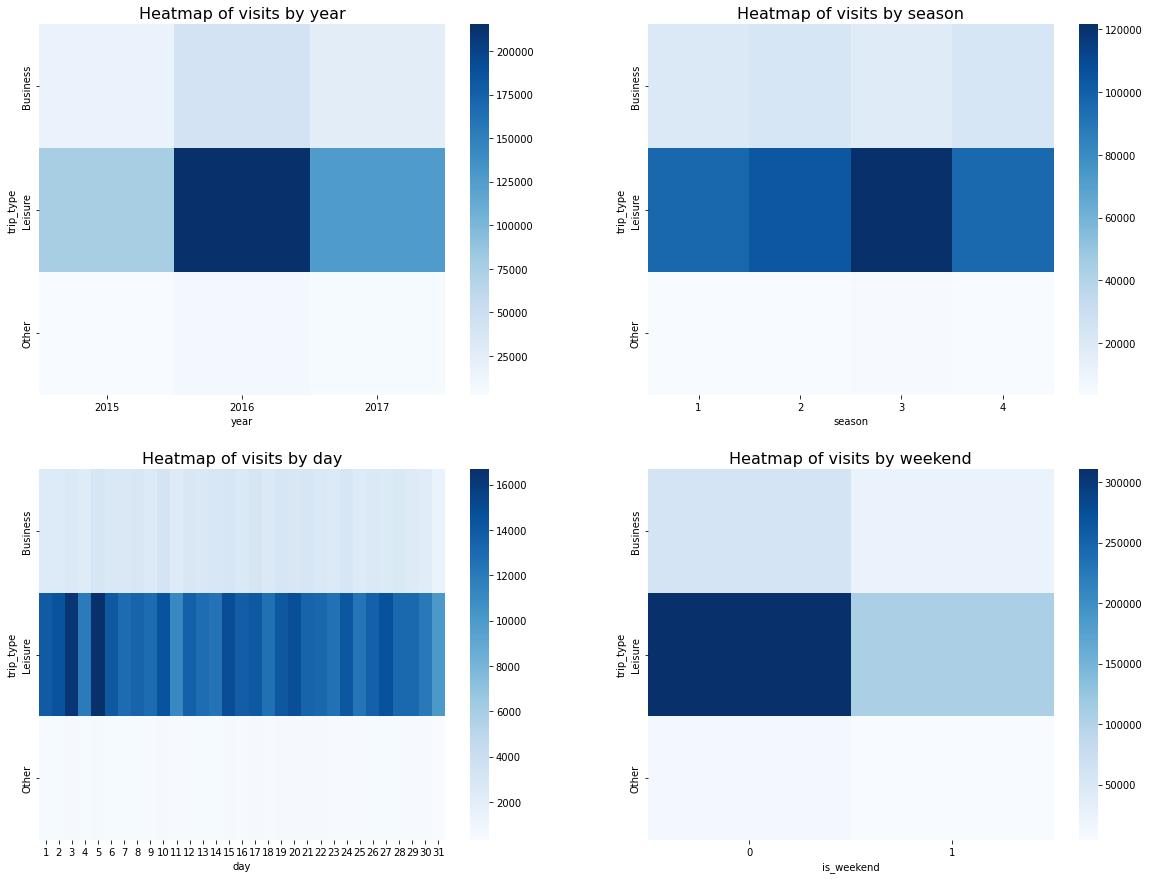

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

heatmap = sns.heatmap(
    data=pivot_year,
    cmap='Blues',
    ax=axes[0,0]
)
heatmap.set_title('Heatmap of visits by year', fontsize=16);

heatmap = sns.heatmap(
    data=pivot_season,
    cmap='Blues',
    ax=axes[0,1]
)
heatmap.set_title('Heatmap of visits by season', fontsize=16);

heatmap = sns.heatmap(
    data=pivot_day,
    cmap='Blues',
    ax=axes[1,0]
)
heatmap.set_title('Heatmap of visits by day', fontsize=16);

heatmap = sns.heatmap(
    data=pivot_weekend,
    cmap='Blues',
    ax=axes[1,1]
)
heatmap.set_title('Heatmap of visits by weekend', fontsize=16);

* **Leisure trip**:
    - peak year - 2016
    - peak season - summer
    - peak day of month - 1-5
    - Working days
    
    
* **Business trip**:
    - peak year - 2016
    - lowest attendance season - summer
    - Working days

In [50]:
data = data.drop('season', axis=1)

In [51]:
# Creating 2 df with mask by trip type
data_business = data[(data['trip_type'] == 'Business')]
data_leisure = data[(data['trip_type'] == 'Leisure')]

# Getting business/ leisure trip df with number of guest in each month
business_trip = data_business.groupby(['month'])['reviewer_nationality'].count().reset_index()
leisure_trip = data_leisure.groupby(['month'])['reviewer_nationality'].count().reset_index()

# Merging of df
final_trip = business_trip.merge(leisure_trip, on = 'month')
final_trip.columns = ['month', 'cnt of business guest', 'cnt of leisure guest']
final_trip

,month,cnt of business guest,cnt of leisure guest
0,1,6235,34668
1,2,7510,29592
2,3,8295,31555
3,4,7111,34533
4,5,7418,37732
5,6,6645,35065
6,7,6254,41518
7,8,4401,44928
8,9,6518,34656
9,10,8544,34081


In [52]:
plt.figure(figsize = (17, 8))

px.line(
    final_trip,
    x = 'month',
    y = ['cnt of business guest','cnt of leisure guest'],
    title = 'Number of Guests by trip type over the Months',
    template = 'plotly_white'
)

<Figure size 1224x576 with 0 Axes>

* Guests check Leisure trip usually in Summer (August) - vacation time
* ...Business trip usually in Spring (March) and Autumn (October). Less in August.

#### `Look at the distribution of guest number by trip type over the day of week`

In [53]:
trip_weekday = data.groupby(['day_of_week', 'trip_type'])['reviewer_nationality'].count().reset_index()
trip_weekday.columns = ['day of week', 'trip type', 'guests cnt']
trip_weekday

,day of week,trip type,guests cnt
0,0,Business,12640
1,0,Leisure,66394
2,0,Other,2111
3,1,Business,12795
4,1,Leisure,104902
5,1,Other,3251
6,2,Business,8945
7,2,Leisure,47874
8,2,Other,1772
9,3,Business,15603


In [54]:
day_of_week = {
    0: 'Monday',
    1: 'Tuesday',
    2: 'Wednesday',
    3: 'Thursday',
    4: 'Friday',
    5: 'Saturday',
    6: 'Sunday'
}

trip_weekday['day of week'] = trip_weekday['day of week'].map(day_of_week)

In [55]:
px.bar(trip_weekday,
       x = 'day of week',
       y = 'guests cnt',
       color = 'trip type',
       barmode = 'group',
       title = 'Number of Guests by trip type over the day of week',
       template = 'plotly_white'
      )

* Peak day for visitors by Leisure trip: Tuesday (for all visitors type - group, solo traveler, couple, etc.)
* Peak day for visitors by Business trip: Thursday and Sunday (night before working day)

Maybe for us it's unusual situation

#### `Look at the distribution of guest number by type of visitors: Group, Couple, Solo, Family, Friends`

In [56]:
# Creating new column with type of visitors (status)
data['guest_status'] = data['tags_n'].apply(lambda x: 'Group' if 'Group' in x \
                                         else 'Couple' if 'Couple' in x \
                                         else 'Solo' if 'Solo traveler' in x \
                                         else 'Family' if 'Family with young children' in x or 'Family with older children' in x \
                                         else 'Friends' if 'Travelers with friends' in x \
                                         else 'Not known')
# Creating 4 df with mask by guest status
data_group = data[(data['guest_status'] == 'Group')]
data_couple = data[(data['guest_status'] == 'Couple')]
data_solo = data[(data['guest_status'] == 'Solo')]
data_family = data[(data['guest_status'] == 'Family')]
data_friends = data[(data['guest_status'] == 'Friends')]

# Getting group/ couple/ solo/ family type of visitors df with number of guest in each month
group = data_group.groupby(['month'])['reviewer_nationality'].count().reset_index()
couple = data_couple.groupby(['month'])['reviewer_nationality'].count().reset_index()
solo = data_solo.groupby(['month'])['reviewer_nationality'].count().reset_index()
family = data_family.groupby(['month'])['reviewer_nationality'].count().reset_index()
friends = data_friends.groupby(['month'])['reviewer_nationality'].count().reset_index()

In [57]:
# define list of df
dfs = [group, couple, solo, family, friends]

# merge all dfs into one
final_df_status = reduce(lambda left, right:
                         pd.merge(left,
                                  right,
                                  on=['month'],
                                  how='outer'),
                         dfs)

final_df_status.columns = ['month', 'group_cnt', 'couple_cnt', 'solo_cnt', 'family_cnt', 'friends_cnt']
final_df_status

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Passing 'suffixes' which cause duplicate columns {'reviewer_nationality_x'} in the result is deprecated and will raise a MergeError in a future version.



,month,group_cnt,couple_cnt,solo_cnt,family_cnt,friends_cnt
0,1,4470,22263,8138,7159,121
1,2,4124,18016,11078,5050,102
2,3,5666,19871,9345,6071,157
3,4,5540,19661,8663,8841,178
4,5,6735,23000,9410,7045,300
5,6,6628,21335,8713,5876,344
6,7,6988,23073,8895,10002,360
7,8,5828,23840,8090,12747,167
8,9,4769,21397,8972,7158,132
9,10,5527,21836,10163,6216,101


In [58]:
plt.figure(figsize = (17, 8))

px.line(
    final_df_status,
    x = 'month',
    y = ['group_cnt', 'couple_cnt', 'solo_cnt', 'family_cnt', 'friends_cnt'],
    title = 'Number of Guests type over the Months',
    template = 'plotly_white'
)

<Figure size 1224x576 with 0 Axes>

* Most visitors are Couple
    - Peak months for visitors: August
    - Lowest attendance in February and November
* On the 2d place Solo traveler
    - Peak months for visitors: February and October
    - Lowest attendance in January and August 
* On the 3d place Family visitors (with young and older children)
    - Peak months for visitors: August
    - Lowest attendance in November (school time)
* On the 4th place Group traveler
    - Peak months for visitors: May, June, July
    - Lowest attendance in February
* At the last place Friends traveler:
    - Peak months for visitors: June, July
    - Lowest attendance in November, December

***

#### `Hotel Room`

In [59]:
"""
Function to get room occupancy
"""
def get_room_occupancy(tag_list):
    for tag in tag_list:
        if 'Single' in tag:
            return 'Single'
        elif ('Double' in tag) or ('Twin' in tag):
            return 'Double'
        elif 'Triple' in tag:
            return 'Triple'
        elif 'Quad' in tag:
            return 'Quad'

        
data['room_occupancy'] = data['tags_n'].apply(get_room_occupancy)

In [60]:
# Filling MV with guest_status value
data['room_occupancy'] = data['room_occupancy'].fillna(data['guest_status'])

# Creating dict for changing str value to numeric
room_occupancy = {
    'Single': 1,
    'Double': 2,
    'Triple': 3,
    'Quad': 4,
    'Solo': 1,
    'Couple': 2,
    'Friends': 3,
    'Family': 4,
    'Group': 5
}

data['room_occupancy'] = data['room_occupancy'].map(room_occupancy)

In [61]:
"""
Function to flag room with view
"""
def flag_view_room(tag_list):
    for tag in tag_list:
        if ('View' in tag) or ('Terrace' in tag):
            return 1
    
data['room_with_view'] = data['tags_n'].apply(flag_view_room)
data['room_with_view'] = data['room_with_view'].fillna(0)
data['room_with_view'] = data['room_with_view'].astype('int64')

***

#### `Positive and Negative Review`

* From the Description of columns we know that in situation when there is not review it marks as 'No Negative/ Positive'.
* It is necessary to change this phrase in order to get correct result in Sentiment Analyse.

In [62]:
def word_count(review):
    """Function to count number of word in review"""
    review_list = review.split(' ')
    counter = 0  
    for el in review_list:
        counter += 1
        
    return counter


# print(data['negative_review'][7].unique())
# print(data['negative_review'][7].apply(word_count).unique())

# print(data['positive_review'][7].unique())
# print(data['positive_review'][7].apply(word_count).unique())

print(data['negative_review'][1])
print(word_count(data['negative_review'][1]))
print()
print(data['positive_review'][1])
print(word_count(data['positive_review'][1]))

 No tissue paper box was present at the room
10

No Positive
2


In [63]:
data['negative_review'] = data['negative_review'].apply(lambda x: x.replace('No Negative', ''))
data['positive_review'] = data['positive_review'].apply(lambda x: x.replace('No Positive', ''))

Let's look at the relationship between word count in review (neg/ pos) and reviewer score

In [64]:
data_with_score = data[data['sample'] == 1]

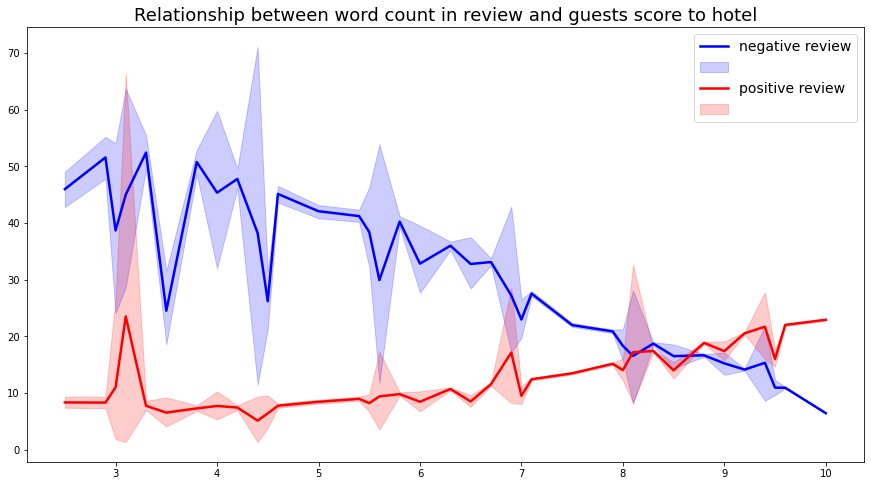

In [65]:
fig, ax = plt.subplots(figsize=(15,8))

sns.lineplot(data=data_with_score,
             x='reviewer_score',
             y='review_total_negative_word_counts',
             color='blue',
             linewidth=2.5             
            );

sns.lineplot(data=data_with_score,
             x='reviewer_score',
             y='review_total_positive_word_counts',
             color='red',
             linewidth=2.5
            );

plt.title('Relationship between word count in review and guests score to hotel', fontsize=18);
ax.set_xlabel('');
ax.set_ylabel('');
ax.legend(['negative review', '', 'positive review', ''], fontsize=14);

#### As you can see higher negative word counts indicate a lower score

Let's adding sentiment analysis features in order to convert guests mood to numeric value.
We use Vader. It is a part of the NLTK module. Vader retuns 4 values for each text:

* neutrality score
* positivity score
* negativity score
* compound - overall score that summarizes the previous scores

We will integrate those 4 values as features in our dataset.

In [66]:
sent_analyzer = SentimentIntensityAnalyzer()

# Getting dict values with keys: 'neg', 'neu', 'pos', 'compound' - for each review
data['review_neg'] = data['negative_review'].apply(lambda x: sent_analyzer.polarity_scores(x))
data['review_pos'] = data['positive_review'].apply(lambda x: sent_analyzer.polarity_scores(x))

# Repacking dict values to independent columns
data.loc[:,['n_neg', 'n_neu', 'n_pos', 'n_compound']] = list(data['review_neg'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)
data.loc[:,['p_neg', 'p_neu', 'p_pos', 'p_compound']] = list(data['review_pos'].apply(lambda x: [x['neg'], x['neu'], x['pos'], x['compound']]).values)

data.head(2)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,review_neg,review_pos,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,"{'neg': 0.129, 'neu': 0.747, 'pos': 0.125, 'co...","{'neg': 0.0, 'neu': 0.671, 'pos': 0.329, 'comp...",0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,,0,...,"{'neg': 0.216, 'neu': 0.784, 'pos': 0.0, 'comp...","{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound...",0.216,0.784,0.000,-0.2960,0.0,0.000,0.000,0.0000


In [67]:
data = data.drop(['review_neg', 'review_pos'], axis=1)

***

#### `Total number of reviews`
-> Let's check if this refers to the reviews in the dataset or not.

In [68]:
data['neg_review_bool'] = data['negative_review'].apply(lambda x: 1 if x != '' else 0)
data['pos_review_bool'] = data['positive_review'].apply(lambda x: 1 if x != '' else 0)

In [69]:
data.head()

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,n_neg,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound,neg_review_bool,pos_review_bool
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0.129,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615,1,1
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,,0,...,0.216,0.784,0.000,-0.2960,0.0,0.000,0.000,0.0000,1,0
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,351,Nice welcoming and service,5,...,0.000,1.000,0.000,0.0000,0.0,0.260,0.740,0.6908,1,1
3,Piazza Della Repubblica 17 Central Station 201...,241,9.1,Hotel Principe Di Savoia,United States of America,,0,1543,Everything including the nice upgrade The Hot...,27,...,0.000,0.000,0.000,0.0000,0.0,0.621,0.379,0.9153,0,1
4,Singel 303 309 Amsterdam City Center 1012 WJ A...,834,9.1,Hotel Esther a,United Kingdom,,0,4687,Lovely hotel v welcoming staff,7,...,0.000,0.000,0.000,0.0000,0.0,0.230,0.770,0.7717,0,1


In [70]:
# Getting temporary df: hotel name and number of reviews
pos_review_cnt = data.groupby(['hotel_name'])['pos_review_bool'].sum().reset_index()
neg_review_cnt = data.groupby(['hotel_name'])['neg_review_bool'].sum().reset_index()
no_review_cnt = data.groupby(['hotel_name'])['additional_number_of_scoring'].max().reset_index()

# define list of df
dfs = [pos_review_cnt, neg_review_cnt, no_review_cnt]

# merge all dfs into one
final_rev_cnt = reduce(lambda left, right:
                         pd.merge(left,
                                  right,
                                  on=['hotel_name'],
                                  how='outer'),
                         dfs)

print('Number of reviews of Urban Lodge Hotel: ')
print()
display(final_rev_cnt[final_rev_cnt['hotel_name'] == 'Urban Lodge Hotel'])

print('\nTotal number of Urban Lodge Hotel reviews accordance to column value: ')
display(list(data[data['hotel_name'] == 'Urban Lodge Hotel']['total_number_of_reviews'].unique()))

Number of reviews of Urban Lodge Hotel: 



,hotel_name,pos_review_bool,neg_review_bool,additional_number_of_scoring
1447,Urban Lodge Hotel,1025,726,612



Total number of Urban Lodge Hotel reviews accordance to column value: 


[5018]

#### Maybe it has more sense to create column with total number of reviews accordance to this dataset.

In [71]:
final_rev_cnt['total_number'] = final_rev_cnt['pos_review_bool'] + final_rev_cnt['neg_review_bool'] + final_rev_cnt['additional_number_of_scoring']
final_rev_cnt = final_rev_cnt.drop(['pos_review_bool', 'neg_review_bool', 'additional_number_of_scoring'], axis=1)
final_rev_cnt_dict = dict(zip(final_rev_cnt['hotel_name'], final_rev_cnt['total_number']))

In [72]:
data['number_of_reviews_df'] = data['hotel_name'].map(final_rev_cnt_dict)
data.head(2)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,...,n_neu,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound,neg_review_bool,pos_review_bool,number_of_reviews_df
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,...,0.747,0.125,-0.0554,0.0,0.671,0.329,0.9615,1,1,4186
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,,0,...,0.784,0.000,-0.2960,0.0,0.000,0.000,0.0000,1,0,2363


In [73]:
data = data.drop('total_number_of_reviews', axis=1)

***

#### `Average Score`
-> Let's calculate our own average based on the reviews scores in the dataset

In [74]:
av_score = data.groupby(['hotel_name'])['reviewer_score'].median().reset_index()
# data[data['hotel_name'] == '1K Hotel']['average_score'].unique() - 7.7 point

av_score_dict = dict(zip(av_score['hotel_name'], av_score['reviewer_score']))

In [75]:
data['av_score_df'] = data['hotel_name'].map(av_score_dict)
data.head(3)

,hotel_address,additional_number_of_scoring,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,n_pos,n_compound,p_neg,p_neu,p_pos,p_compound,neg_review_bool,pos_review_bool,number_of_reviews_df,av_score_df
0,Via Senigallia 6 20161 Milan Italy,904,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,Hotel was great clean friendly staff free bre...,62,1,...,0.125,-0.0554,0.0,0.671,0.329,0.9615,1,1,4186,7.5
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,,0,7,...,0.000,-0.2960,0.0,0.000,0.000,0.0000,1,0,2363,8.8
2,Mallorca 251 Eixample 08008 Barcelona Spain,46,8.3,Alexandra Barcelona A DoubleTree by Hilton,Sweden,Pillows,3,Nice welcoming and service,5,15,...,0.000,0.0000,0.0,0.260,0.740,0.6908,1,1,179,7.9


In [76]:
data = data.drop('average_score', axis=1)

***

#### `Proportion of word count in positive review`

In [77]:
data['total_number_word_counts'] = \
    data['review_total_negative_word_counts'] + \
    data['review_total_positive_word_counts']

# if total number = 0, let's get proportion value 50/50
data['pos_rev_word_proportion'] = data.apply(
    lambda x: 0.5 if x['total_number_word_counts'] == 0 \
             else round(x['review_total_positive_word_counts'] /  x['total_number_word_counts'], 2), axis=1)

# delete temp column
data = data.drop('total_number_word_counts', axis = 1)

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 50 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515738 non-null  object 
 1   additional_number_of_scoring                515738 non-null  int64  
 2   hotel_name                                  515738 non-null  object 
 3   reviewer_nationality                        515738 non-null  object 
 4   negative_review                             515738 non-null  object 
 5   review_total_negative_word_counts           515738 non-null  int64  
 6   positive_review                             515738 non-null  object 
 7   review_total_positive_word_counts           515738 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 9   tags                                        515738 non-null  object 
 

***

In [79]:
# Encoding features
data['leisure_trip'] = data['trip_type'].apply(lambda x: 1 if x == 'Leisure' else 0)
data['business_trip'] = data['trip_type'].apply(lambda x: 1 if x == 'Business' else 0)

In [80]:
# One-Hot Encoding
encoder = ce.OneHotEncoder()
features_bin = encoder.fit_transform(data[['hotel_country', 'guest_status']])
data = pd.concat([data, features_bin], axis=1)

In [81]:
data = data.drop(['trip_type', 'hotel_country', 'guest_status'], axis=1)

In [82]:
# Delete columns with dtypes object
object_columns = [s for s in data.columns if data[s].dtypes == 'object']

data.drop(object_columns, axis = 1, inplace=True)

In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515738 entries, 0 to 515737
Data columns (total 51 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                515738 non-null  int64  
 1   review_total_negative_word_counts           515738 non-null  int64  
 2   review_total_positive_word_counts           515738 non-null  int64  
 3   total_number_of_reviews_reviewer_has_given  515738 non-null  int64  
 4   days_since_review                           515738 non-null  int64  
 5   lat                                         515738 non-null  float64
 6   lng                                         515738 non-null  float64
 7   sample                                      515738 non-null  int64  
 8   reviewer_score                              515738 non-null  float64
 9   year                                        515738 non-null  int64  
 

***

# <p style="text-align:center;font-size:100%;">6. Feature Selection</p>

In [84]:
# Created temp (copy) data in order to have possibility come back
data_temp = data

I don't delete duplicates and outliers that's why I guess that our columns have abnormal distribution

-> Let's use Spearman corr to check existing correlation between columns.

<AxesSubplot:>

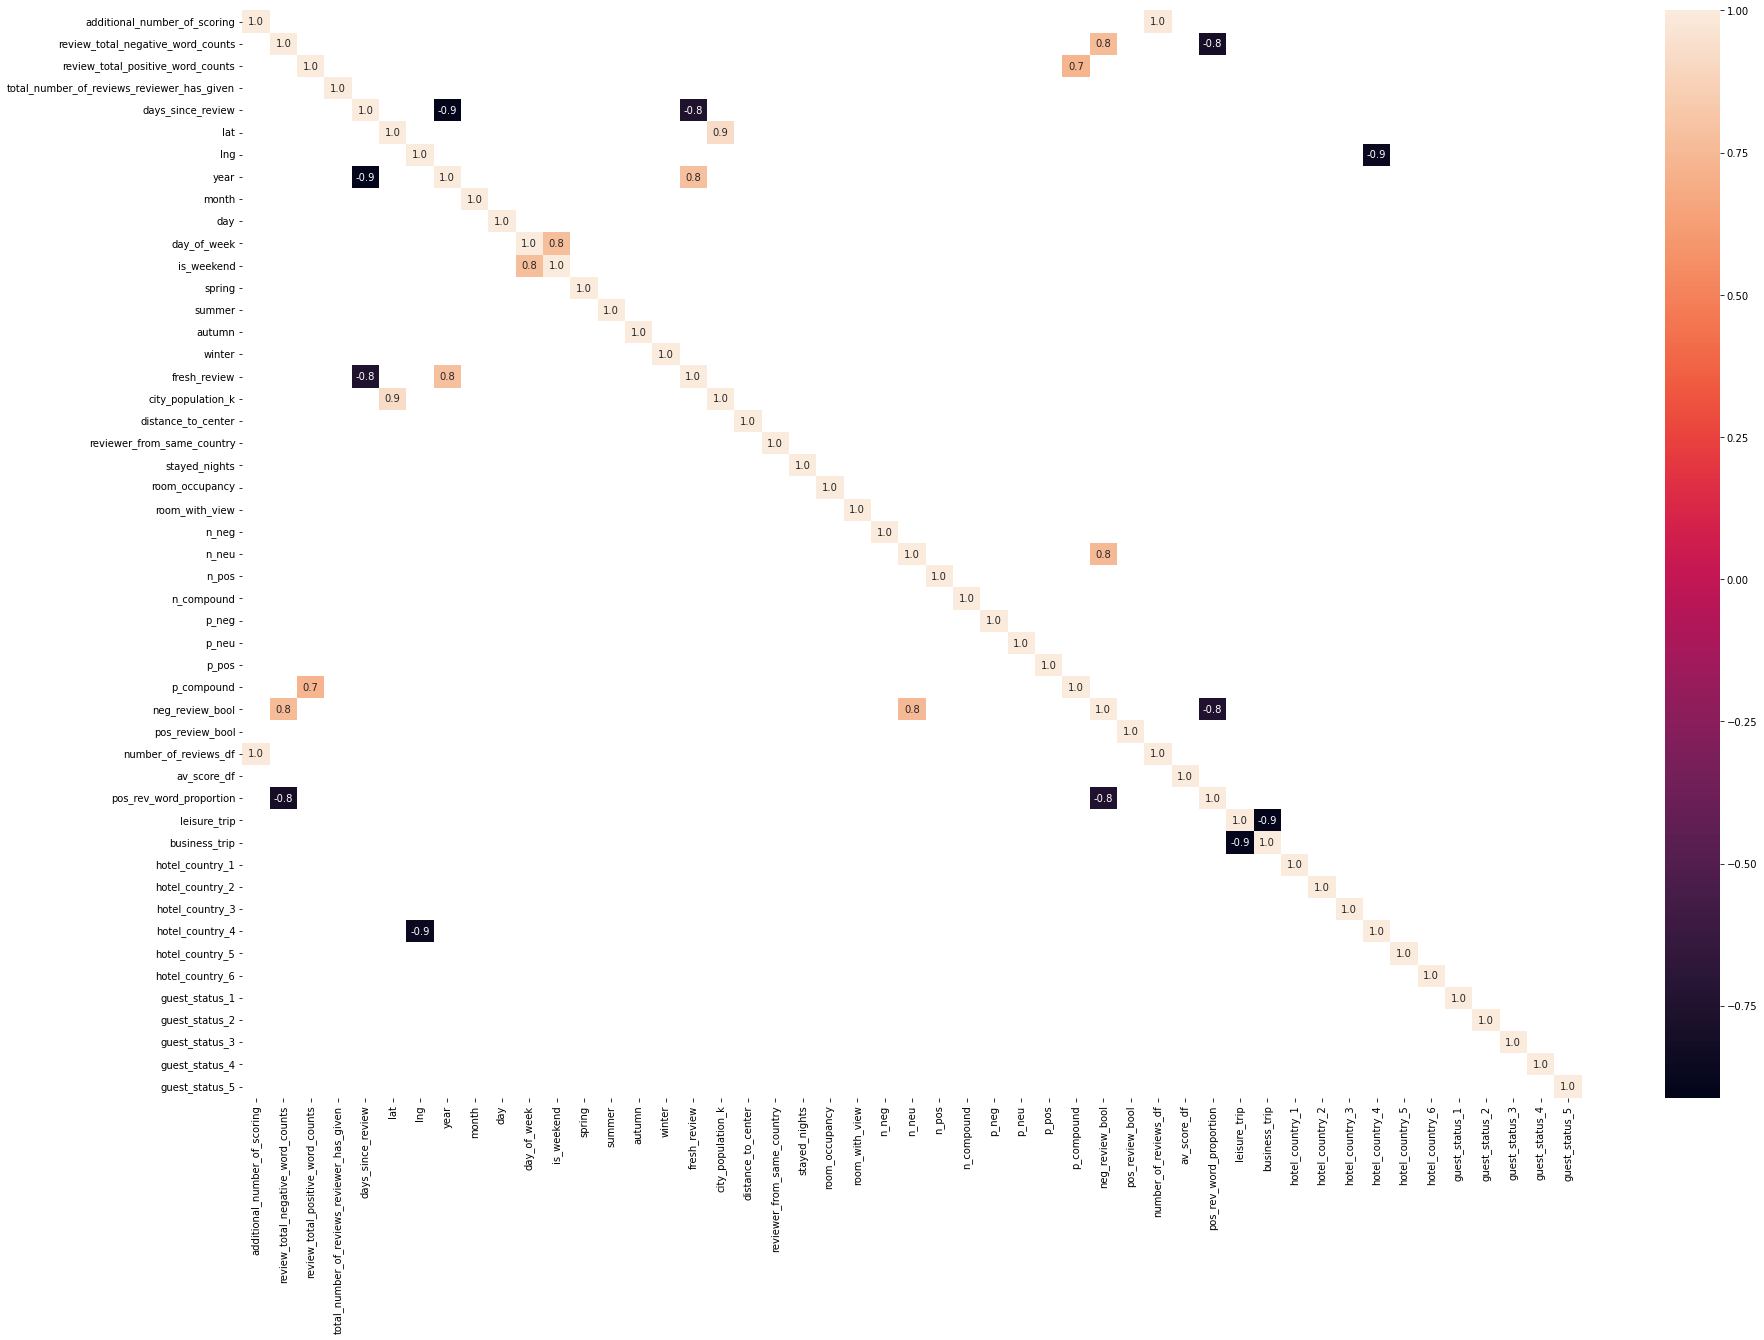

In [85]:
# creating correlation heatmap by using spearman method 
corr_data = data_temp.drop(['sample', 'reviewer_score'], axis=1).corr(method='spearman')

plt.rcParams['figure.figsize'] = (30,20)

sns.heatmap(corr_data[corr_data.abs() > 0.7], annot = True,  fmt='.1f')

I guess that it will be better if we separate our features:
* numeric & categorical

In [86]:
# numeric and categorical values
num_cols = [
    # word counts:
    'review_total_negative_word_counts', 'review_total_positive_word_counts',
    'pos_rev_word_proportion',

     # sentiment value of review:
    'n_neg', 'n_neu', 'n_pos', 'n_compound',
    'p_neg', 'p_neu', 'p_pos', 'p_compound',
    
    # hotel features
    'additional_number_of_scoring','av_score_df',
    'number_of_reviews_df', 'total_number_of_reviews_reviewer_has_given',
    'distance_to_center','city_population_k', 'lat', 'lng',
    
    # room / trip features
    'room_occupancy',
    
    # guest features
    'stayed_nights',
    
    # review
    'days_since_review'
]

cat_cols = [
    # hotel features
    'hotel_country_1', 'hotel_country_2', 'hotel_country_3',
    'hotel_country_4', 'hotel_country_5', 'hotel_country_6',

    # room / trip features
    'room_with_view', 'leisure_trip',

    # guest features
    'reviewer_from_same_country',
    'guest_status_1', 'guest_status_2', 'guest_status_3',
    'guest_status_4', 'guest_status_5',

    # trip period
    'year', 'month', 'day', 'day_of_week', 'is_weekend',
    'spring', 'summer', 'autumn', 'winter',

    # review features
    'fresh_review', 'neg_review_bool', 'pos_review_bool'
]

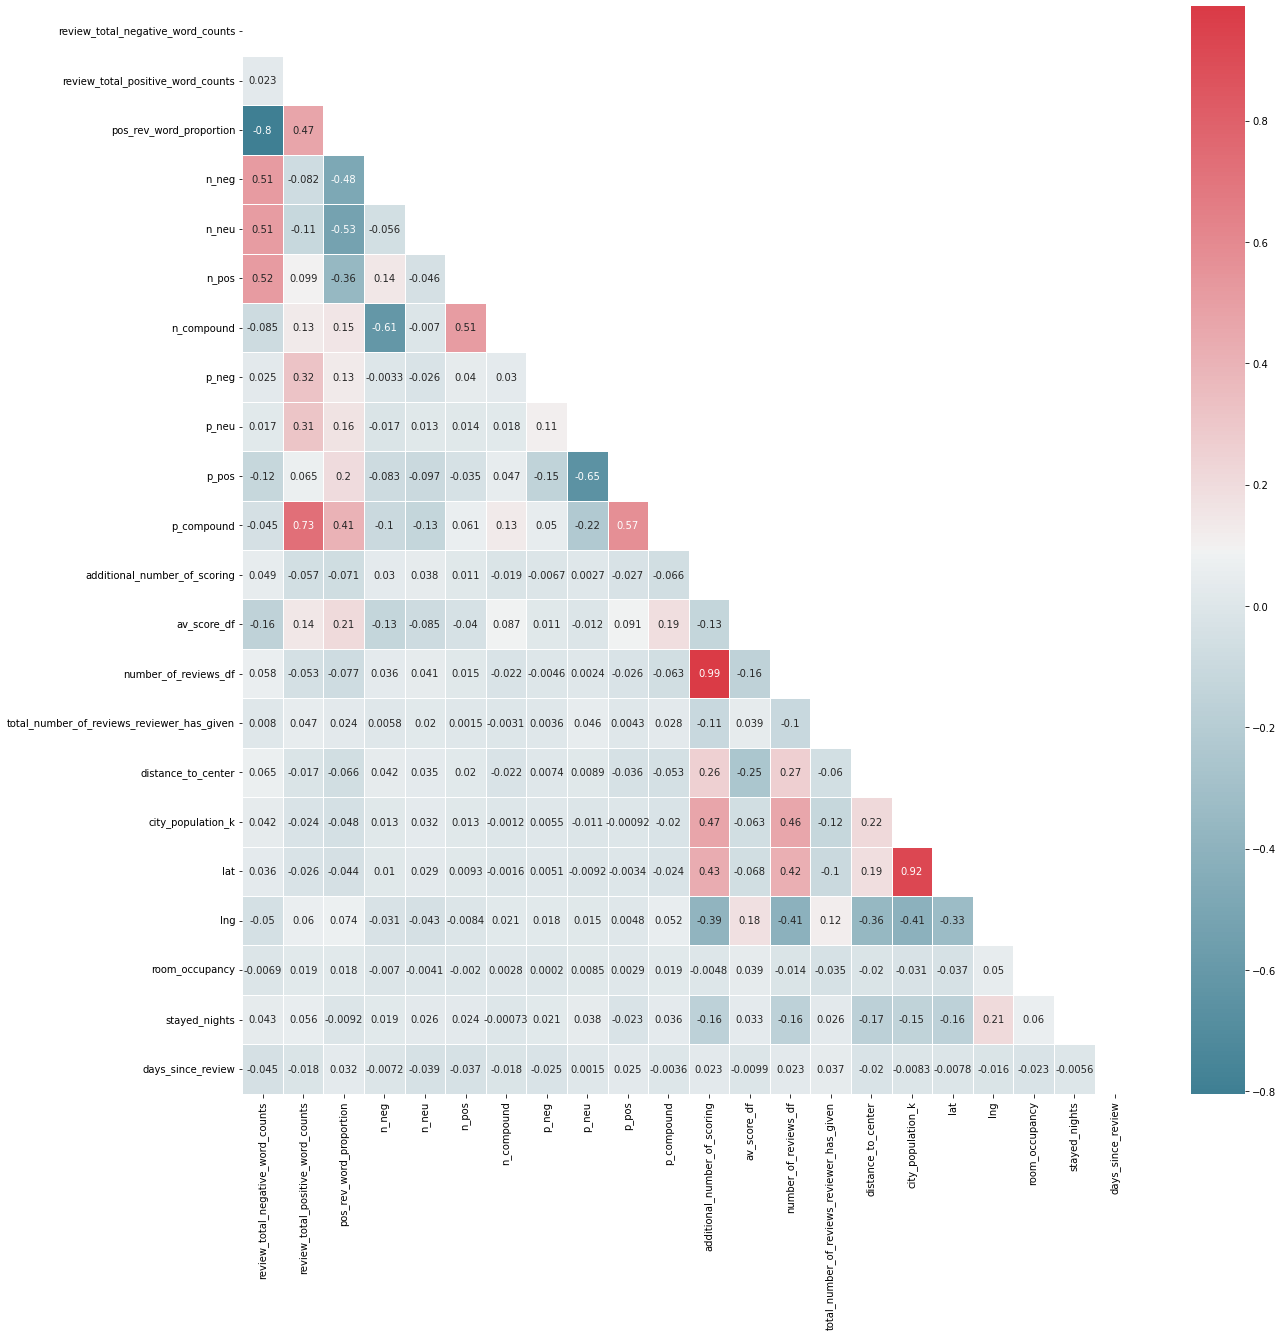

In [87]:
# Creating correlation heatmap - spearman
num_features = data_temp[num_cols]

# Params for graph: color, single corner
mask = np.zeros_like(num_features.corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(20,20))

sns.heatmap(num_features.corr(method='spearman'), mask=mask, cmap=cmap, linewidths=.6, annot=True, ax=ax)

plt.show();

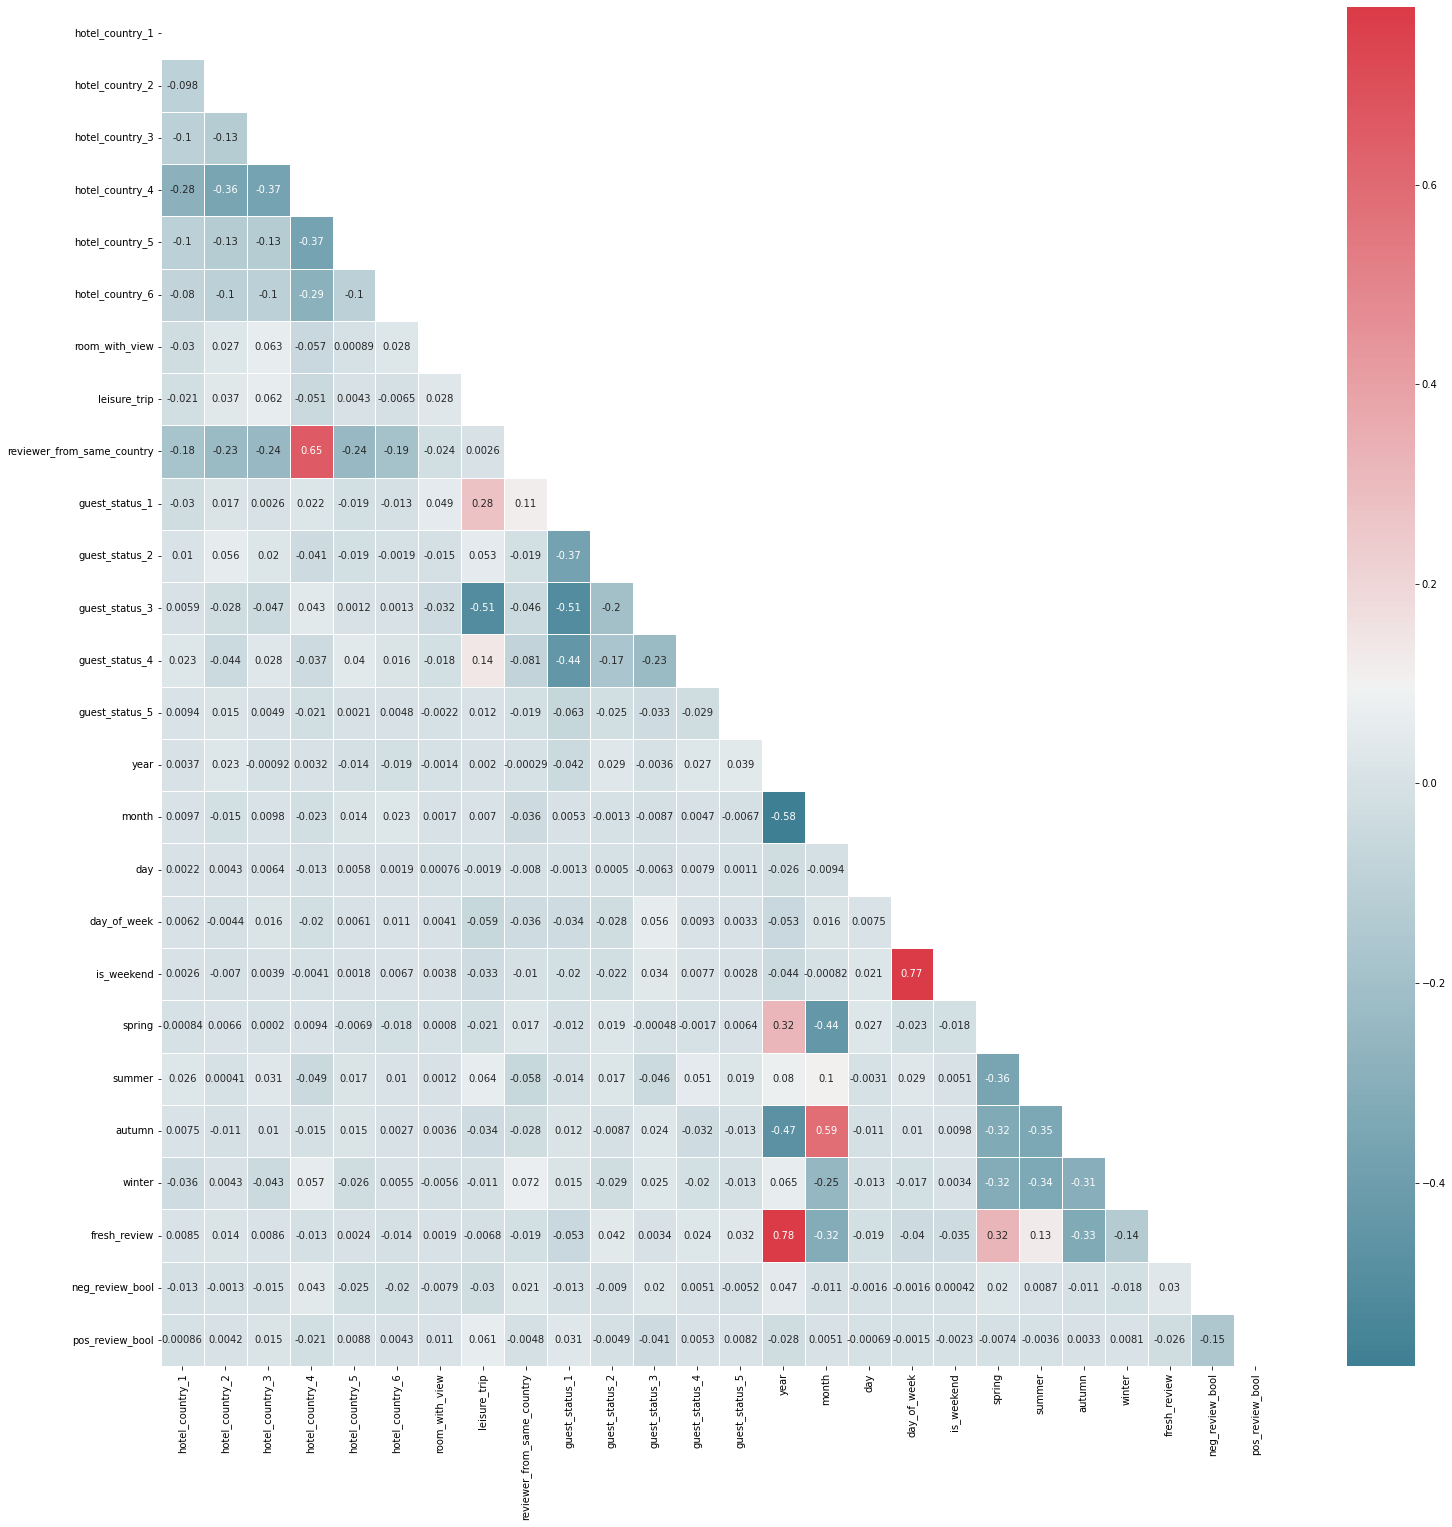

In [88]:
# Creating correlation heatmap - for cat_cols
num_features = data_temp[cat_cols]

# Params for graph: color, single corner
mask = np.zeros_like(num_features.corr(method='spearman'), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)
fig, ax = plt.subplots(figsize=(25,25))

sns.heatmap(num_features.corr(method='spearman'), mask=mask, cmap=cmap, linewidths=.6, annot=True, ax=ax)

plt.show();

In [89]:
# Drop columns
data_temp = data_temp.drop(['additional_number_of_scoring', 'is_weekend', 'year', 'city_population_k'], axis=1)

In [90]:
# data_temp.var() # normalizing numerical variables is not necessary

# <p style="text-align:center;font-size:100%;">7. Machine Learning</p>

In [91]:
# dividing dataset into train and test
train_df = data_temp.query('sample == 1').drop(['sample'], axis=1)
test_df = data_temp.query('sample == 0').drop(['sample'], axis=1)

y = train_df.reviewer_score.values # target value
X = train_df.drop(['reviewer_score'], axis=1)

In [92]:
# dividing for train и validation data (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [93]:
# Checking
test_df.shape, train_df.shape, X.shape, X_train.shape, X_test.shape

((128935, 46), (386803, 46), (386803, 45), (309442, 45), (77361, 45))

In [94]:
# Model
model = RandomForestRegressor(
    n_estimators=100,
    verbose=1,
    n_jobs=-1,
    random_state=RANDOM_SEED)

In [95]:
%%time

# Training model on train data
model.fit(X_train, y_train)

# y_pred - predicted values
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.0s


CPU times: user 18min 38s, sys: 3.95 s, total: 18min 42s
Wall time: 4min 49s


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.4s finished


In [96]:
# Function to calculate MAPE
def mape_func(y_tr, y_pr):
    mape = np.mean(np.abs((y_tr - y_pr)/y_tr))*100
    return mape

print('MAPE:', round(mape_func(y_test, y_pred), 5))

MAPE: 12.58869


<AxesSubplot:>

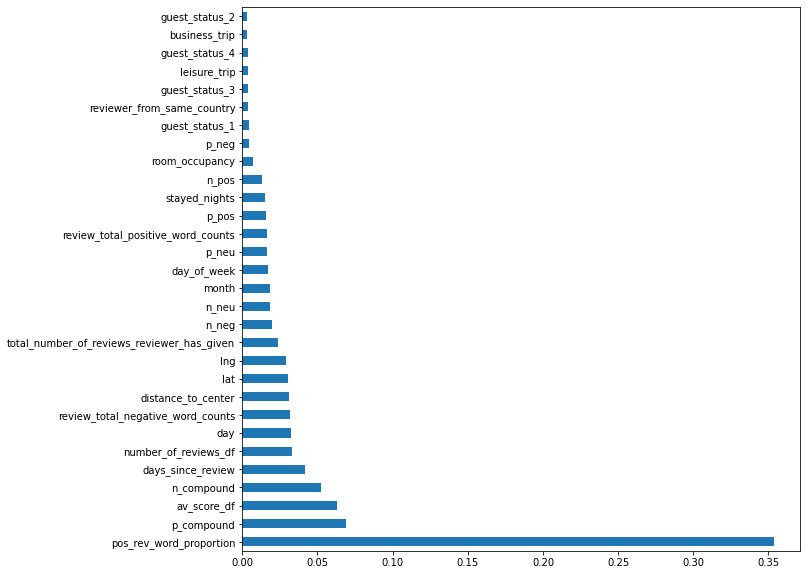

In [102]:
# meaningful features
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(30).plot(kind='barh')

In [98]:
test_df = test_df.drop(['reviewer_score'], axis=1)

predict_submission = model.predict(test_df)
sample_submission['reviewer_score'] = predict_submission

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    1.6s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    4.0s finished


In [103]:
# Saving result
sample_submission.to_csv('submission_final.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.700,488440
1,7.688,274649
2,8.186,374688
3,9.709,404352
4,9.554,451596
5,8.976,302161
6,7.579,317079
7,7.253,13963
8,8.480,159785
9,7.672,195089
